# Exploring possible targets for XMM - 2023

## Import Statements

In [1]:
# import pandas as pd
# import numpy as np
# from astropy.units import Quantity
# from astropy.io import fits
# from astropy.table import Table
# from astropy.cosmology import LambdaCDM
# from astropy.coordinates import SkyCoord
# from matplotlib import pyplot as plt

# from xga.imagetools.profile import annular_mask
# from xga.imagetools.misc import physical_rad_to_pix
# from xga.products import ExpMap

# %matplotlib inline

In [2]:
from astropy.units import Quantity
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import warnings

from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix
from xga.sourcetools.misc import rad_to_ang
from xga.imagetools.profile import annular_mask
from xga.products import ExpMap

%matplotlib inline
warnings.filterwarnings('ignore')

## Define the cosmology

In [3]:
cosmo = FlatLambdaCDM(70, 0.3)

## Read in the sample

In [4]:
# samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
# samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))
# samp

In [5]:
samp = pd.read_csv("../../sample_files/lovoccs_southnorth.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))

check = pd.read_csv("../../sample_files/lovoccs_checklist_lite.csv")
check['Name'] = check['Name'].apply(lambda x: x.replace('RXC ', 'RXC').replace("RBS ", "RBS")
                                    .replace("APMCC ", "APMCC").replace("MKW ", "MKW"))


In [6]:
on_other = pd.merge(samp, check, left_on="other_names", right_on="Name", how="right")
on_alt = pd.merge(samp, check, left_on="alt_name", right_on="Name", how="right")
rel_samp = pd.concat([on_other[~on_other['LoVoCCSID'].isna()], 
                      on_alt[~on_alt['LoVoCCSID'].isna()]]).drop_duplicates('LoVoCCSID')
rel_samp['LoVoCCSID'] = rel_samp['LoVoCCSID'].astype(int)
rel_samp = rel_samp.reset_index(drop=True)
rel_samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments
0,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN,south,LoVoCCS-1,1,A2029,227.73,5.72,0.0766,1.0,yes,"with A2033, southern infalling group"
1,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L,south,LoVoCCS-2,2,A401,44.74,13.58,0.0739,1.0,yes,Bridge of galaxies between A401/A399 -- simila...
2,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr",south,LoVoCCS-4,3,A85,10.46,-9.30,0.0555,1.0,yes,NaN
3,MCXCJ2012.5-5649,J2012.5-5649,901,303.127100,-56.831900,0.0556,4.871933,5.1696,1.1990,RXCJ2012.5-5649,A3667,"L,losStr",south,LoVoCCS-901,4,A3667,303.13,-56.83,0.0556,1.0,yes,NaN
4,MCXCJ2201.9-5956,J2201.9-5956,6,330.483333,-59.949444,0.0980,4.204419,4.5890,1.1367,RXCJ2201.9-5956,A3827,NaN,south,LoVoCCS-6,5,A3827,330.48,-59.95,0.0980,1.0,yes,Currently using A3825 catalogs. Note the 2 clu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,MCXCJ1332.9-2519,J1332.9-2519,113,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,RXCJ1332.9-2519,NaN,X,south,LoVoCCS-113,86,RXCJ1332.9-2519,203.23,-25.32,0.1199,1.0,yes,Not very clear lensing peak
103,MCXCJ0821.0+0751,J0821.0+0751,116,125.257500,7.866111,0.1100,1.110969,2.0211,0.8614,RXCJ0821.0+0751,RXJ0820.9+0751,NaN,south,LoVoCCS-116,88,RXCJ0821.0+0751,125.26,7.87,0.1100,1.0,yes,NaN
104,MCXCJ2125.2-0657,J2125.2-0657,137,321.301667,-6.965556,0.1153,1.018847,1.9100,0.8438,RXCJ2125.2-0657,NaN,NaN,south,LoVoCCS-137,103,RXCJ2125.2-0657,321.30,-6.97,0.1153,NaN,partially,NaN
105,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X,south,LoVoCCS-141,106,RXCJ1416.8-1158,214.21,-11.98,0.0982,NaN,no,NaN


In [7]:
check[~check['Name'].isin(rel_samp.Name)]

,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments


In [8]:
obs_samp = rel_samp[rel_samp['Fully observed'] == 'yes']
rel_samp['Fully observed'].value_counts()

Fully observed
yes          82
partially    22
no            2
almost        1
Name: count, dtype: int64

In [9]:
obs_samp['sub_samp'].value_counts()

sub_samp
south    79
north     3
Name: count, dtype: int64

In [21]:
rel_samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,XMM_R500_FRAC,CHANDRA_R500_FRAC
0,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN,south,LoVoCCS-1,A2029,227.73,5.72,0.0766,1.0,yes,"with A2033, southern infalling group",1.000000,1.000000
1,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L,south,LoVoCCS-2,A401,44.74,13.58,0.0739,1.0,yes,Bridge of galaxies between A401/A399 -- simila...,0.998862,1.000000
2,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr",south,LoVoCCS-4,A85,10.46,-9.30,0.0555,1.0,yes,NaN,0.992639,1.000000
3,MCXCJ2012.5-5649,J2012.5-5649,901,303.127100,-56.831900,0.0556,4.871933,5.1696,1.1990,RXCJ2012.5-5649,A3667,"L,losStr",south,LoVoCCS-901,A3667,303.13,-56.83,0.0556,1.0,yes,NaN,0.999690,0.966663
4,MCXCJ2201.9-5956,J2201.9-5956,6,330.483333,-59.949444,0.0980,4.204419,4.5890,1.1367,RXCJ2201.9-5956,A3827,NaN,south,LoVoCCS-6,A3827,330.48,-59.95,0.0980,1.0,yes,Currently using A3825 catalogs. Note the 2 clu...,1.000000,0.676043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,MCXCJ1332.9-2519,J1332.9-2519,113,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,RXCJ1332.9-2519,NaN,X,south,LoVoCCS-113,RXCJ1332.9-2519,203.23,-25.32,0.1199,1.0,yes,Not very clear lensing peak,0.000000,0.000000
103,MCXCJ0821.0+0751,J0821.0+0751,116,125.257500,7.866111,0.1100,1.110969,2.0211,0.8614,RXCJ0821.0+0751,RXJ0820.9+0751,NaN,south,LoVoCCS-116,RXCJ0821.0+0751,125.26,7.87,0.1100,1.0,yes,NaN,1.000000,0.969115
104,MCXCJ2125.2-0657,J2125.2-0657,137,321.301667,-6.965556,0.1153,1.018847,1.9100,0.8438,RXCJ2125.2-0657,NaN,NaN,south,LoVoCCS-137,RXCJ2125.2-0657,321.30,-6.97,0.1153,NaN,partially,NaN,0.000000,0.000000
105,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X,south,LoVoCCS-141,RXCJ1416.8-1158,214.21,-11.98,0.0982,NaN,no,NaN,0.000000,0.864928


## X-ray coverage of the LoVoCCS sample

In [10]:
field_xmm_cov_frac = []
r500_xmm_cov_frac = []
rvir_xmm_cov_frac = []

field_chandra_cov_frac = []
r500_chandra_cov_frac = []
rvir_chandra_cov_frac = []

for row_ind, row in rel_samp.iterrows():
    cov_path = "../../outputs/coverage_maps/fits/{n}_550pix_20.0arcsec.fits".format(n=row["LoVoCCS_name"])
    cur_cheese = ExpMap(cov_path, '', '', '', '', '', Quantity(0.5, 'keV'), Quantity(2.0, 'keV'))
    with fits.open(cov_path) as covero:
        if row_ind == 0:
            print(covero[0].header['MISSION*'])
            
        cov_arr = covero[0].data
        xmm_cov_arr = cov_arr[0, :, :]
        chandra_cov_arr = cov_arr[1, :, :]
        
        field_xmm_cov_frac.append(xmm_cov_arr.sum() / (xmm_cov_arr.shape[0]*xmm_cov_arr.shape[1]))
        field_chandra_cov_frac.append(chandra_cov_arr.sum() / (chandra_cov_arr.shape[0]*chandra_cov_arr.shape[1]))
        
        pix_cen = Quantity([xmm_cov_arr.shape[0]/2, xmm_cov_arr.shape[1]/2], 'pix').round(0).astype(int)
        rad = Quantity(row['R500'], 'Mpc')
        
        pix_rad = physical_rad_to_pix(cur_cheese, rad, pix_cen, row['redshift'], cosmo)
        
        rad_mask = annular_mask(pix_cen, np.array([0]), np.array([pix_rad.value]), xmm_cov_arr.shape)
        msk_xmm_cov = xmm_cov_arr*rad_mask
        r500_xmm_cov_frac.append(msk_xmm_cov.sum() / rad_mask.sum())
        
        msk_chandra_cov = chandra_cov_arr*rad_mask
        r500_chandra_cov_frac.append(msk_chandra_cov.sum() / rad_mask.sum())
        
        rel_samp.loc[row_ind, 'XMM_R500_FRAC'] = r500_xmm_cov_frac[row_ind]
        rel_samp.loc[row_ind, 'CHANDRA_R500_FRAC'] = r500_chandra_cov_frac[row_ind]
        
        

MISSION1= 'xmm_pointed'                                                         MISSION2= 'chandra '                                                            MISSION3= 'rosat_pointed_pspc'                                                  MISSION4= 'rosat_pointed_hri'                                                   MISSION5= 'nustar_pointed'                                                      END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [11]:
del rel_samp['ID']
rel_samp.to_csv('for_ray.csv', index=False)

In [12]:
rel_samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,XMM_R500_FRAC,CHANDRA_R500_FRAC
0,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN,south,LoVoCCS-1,A2029,227.73,5.72,0.0766,1.0,yes,"with A2033, southern infalling group",1.000000,1.000000
1,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L,south,LoVoCCS-2,A401,44.74,13.58,0.0739,1.0,yes,Bridge of galaxies between A401/A399 -- simila...,0.998862,1.000000
2,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr",south,LoVoCCS-4,A85,10.46,-9.30,0.0555,1.0,yes,NaN,0.992639,1.000000
3,MCXCJ2012.5-5649,J2012.5-5649,901,303.127100,-56.831900,0.0556,4.871933,5.1696,1.1990,RXCJ2012.5-5649,A3667,"L,losStr",south,LoVoCCS-901,A3667,303.13,-56.83,0.0556,1.0,yes,NaN,0.999690,0.966663
4,MCXCJ2201.9-5956,J2201.9-5956,6,330.483333,-59.949444,0.0980,4.204419,4.5890,1.1367,RXCJ2201.9-5956,A3827,NaN,south,LoVoCCS-6,A3827,330.48,-59.95,0.0980,1.0,yes,Currently using A3825 catalogs. Note the 2 clu...,1.000000,0.676043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,MCXCJ1332.9-2519,J1332.9-2519,113,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,RXCJ1332.9-2519,NaN,X,south,LoVoCCS-113,RXCJ1332.9-2519,203.23,-25.32,0.1199,1.0,yes,Not very clear lensing peak,0.000000,0.000000
103,MCXCJ0821.0+0751,J0821.0+0751,116,125.257500,7.866111,0.1100,1.110969,2.0211,0.8614,RXCJ0821.0+0751,RXJ0820.9+0751,NaN,south,LoVoCCS-116,RXCJ0821.0+0751,125.26,7.87,0.1100,1.0,yes,NaN,1.000000,0.969115
104,MCXCJ2125.2-0657,J2125.2-0657,137,321.301667,-6.965556,0.1153,1.018847,1.9100,0.8438,RXCJ2125.2-0657,NaN,NaN,south,LoVoCCS-137,RXCJ2125.2-0657,321.30,-6.97,0.1153,NaN,partially,NaN,0.000000,0.000000
105,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X,south,LoVoCCS-141,RXCJ1416.8-1158,214.21,-11.98,0.0982,NaN,no,NaN,0.000000,0.864928


In [97]:
rel_samp[rel_samp['LoVoCCSID'] == 53]

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,XMM_R500_FRAC,CHANDRA_R500_FRAC


### Distribution of coverage of 3.06$^{\circ}$x3.06$^{\circ}$ field centered on MCXC position

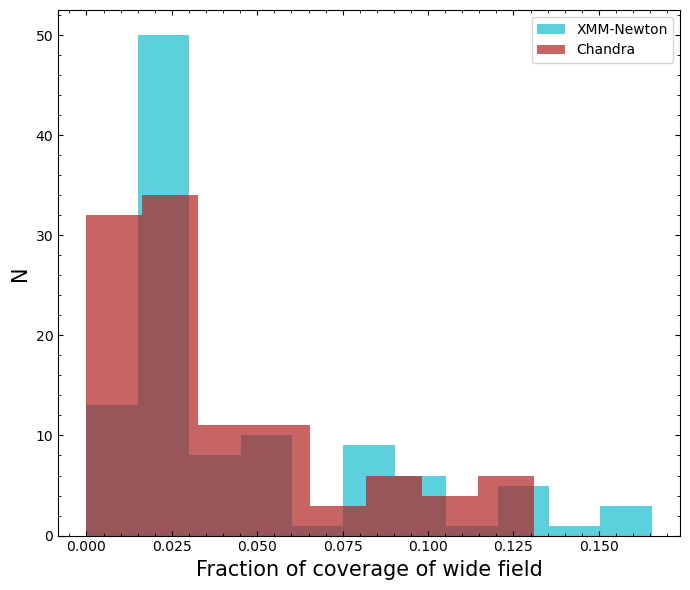

In [13]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(field_xmm_cov_frac, bins='auto', color='tab:cyan', alpha=0.7, label='XMM-Newton')
plt.hist(field_chandra_cov_frac, bins='auto', color='firebrick', alpha=0.7, label='Chandra')
plt.ylabel('N', fontsize=15)
plt.xlabel(r'Fraction of coverage of wide field', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Distribution of coverage of MCXC $R_{500}$ centered on MCXC position

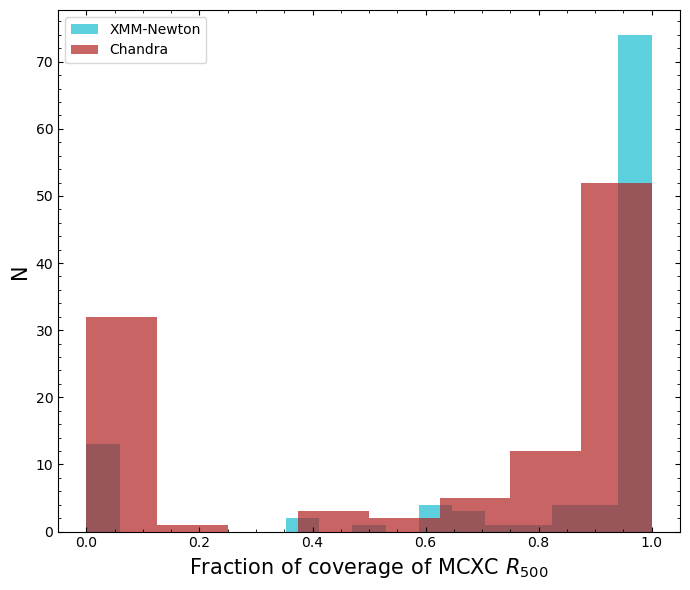

In [14]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(r500_xmm_cov_frac, bins='auto', color='tab:cyan', alpha=0.7, label='XMM-Newton')
plt.hist(r500_chandra_cov_frac, bins='auto', color='firebrick', alpha=0.7, label='Chandra')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'Fraction of coverage of MCXC $R_{500}$', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Possible categories of target

### No non-RASS X-ray coverage

<span style="color:red">LoVoCCS-99 had an incorrect coordinate, and shouldn't appear here once further data have been downloaded</span>

In [28]:
rel_samp.iloc[np.where((np.array(r500_xmm_cov_frac) == 0) & (np.array(r500_chandra_cov_frac) == 0))]

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,XMM_R500_FRAC,CHANDRA_R500_FRAC
60,MCXCJ0028.6-2338,J0028.6-2338,91,7.163750,-23.637222,0.1120,1.404549,2.3285,0.9024,RXCJ0028.6-2338,A42,NaN,south,LoVoCCS-91,A42,7.16,-23.64,0.1120,NaN,partially,NaN,0.0,0.0
72,MCXCJ0107.8-3643,J0107.8-3643,112,16.954583,-36.727222,0.1186,1.156778,2.0589,0.8642,RXCJ0107.8-3643,A2871,NaN,south,LoVoCCS-112,A2871,16.95,-36.73,0.1186,NaN,partially,NaN,0.0,0.0
76,MCXCJ1027.9-0647,J1027.9-0647,119,156.998333,-6.796111,0.1176,1.095941,1.9936,0.8553,RXCJ1027.9-0647,A1023,X *,south,LoVoCCS-119,A1023,157.00,-6.80,0.1176,1.0,yes,NaN,0.0,0.0
100,MCXCJ1139.4-3327,J1139.4-3327,106,174.863750,-33.453889,0.1076,1.218610,2.1420,0.8789,RXCJ1139.4-3327,NaN,NaN,south,LoVoCCS-106,RXCJ1139.4-3327,174.86,-33.45,0.1076,1.0,yes,NaN,0.0,0.0
102,MCXCJ1332.9-2519,J1332.9-2519,113,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,RXCJ1332.9-2519,NaN,X,south,LoVoCCS-113,RXCJ1332.9-2519,203.23,-25.32,0.1199,1.0,yes,Not very clear lensing peak,0.0,0.0
104,MCXCJ2125.2-0657,J2125.2-0657,137,321.301667,-6.965556,0.1153,1.018847,1.9100,0.8438,RXCJ2125.2-0657,NaN,NaN,south,LoVoCCS-137,RXCJ2125.2-0657,321.30,-6.97,0.1153,NaN,partially,NaN,0.0,0.0
106,MCXCJ1459.0-0843,J1459.0-0843,142,224.764583,-8.725000,0.1043,1.001337,1.9047,0.8461,RXCJ1459.0-0843,NaN,NaN,south,LoVoCCS-142,RXCJ1459.0-0843,224.76,-8.73,0.1043,NaN,partially,NaN,0.0,0.0


In [30]:
rel_samp.iloc[np.where((np.array(r500_xmm_cov_frac) <= 0.6) | (np.array(r500_chandra_cov_frac) <= 0.6))]

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,XMM_R500_FRAC,CHANDRA_R500_FRAC
8,MCXCJ1347.4-3250,J1347.4-3250,11,206.868333,-32.849722,0.0391,3.819920,4.5067,1.1514,RXCJ1347.4-3250,A3571,L,south,LoVoCCS-11,A3571,206.87,-32.85,0.0391,1.0,yes,eRosita,0.510430,0.399690
13,MCXCJ0052.7-8015,J0052.7-8015,18,13.187083,-80.266389,0.1141,3.393306,3.9812,1.0783,RXCJ0052.7-8015,A2837,NaN,south,LoVoCCS-18,A2837,13.19,-80.27,0.1141,1.0,yes,NaN,0.000000,1.000000
19,MCXCJ0042.1-2832,J0042.1-2832,28,10.536250,-28.535833,0.1082,2.734146,3.5046,1.0355,RXCJ0042.1-2832,A2811,losStr,south,LoVoCCS-28,A2811,10.54,-28.54,0.1082,1.0,yes,NaN,1.000000,0.000000
22,MCXCJ1130.3-1434,J1130.3-1434,32,172.581250,-14.583056,0.1068,2.605129,3.4062,1.0262,RXCJ1130.3-1434,A1285,NaN,south,LoVoCCS-32,A1285,172.58,-14.58,0.1068,1.0,yes,NaN,0.386311,1.000000
24,MCXCJ2331.2-3630,J2331.2-3630,36,352.802917,-36.506667,0.0957,2.419356,3.2815,1.0172,RXCJ2331.2-3630,A4010,NaN,south,LoVoCCS-36,A4010,352.80,-36.51,0.0957,1.0,yes,Mass map peak offset (reason?). XMM centered a...,1.000000,0.000000
25,MCXCJ1518.7+0613,J1518.7+0613,38,229.690000,6.231111,0.1021,2.241343,3.1180,0.9979,RXCJ1518.7+0613,A2055,C,south,LoVoCCS-38,A2055,229.69,6.23,0.1021,1.0,yes,NaN,1.000000,0.000000
29,MCXCJ2149.1-3041,J2149.1-3041,43,327.280833,-30.698611,0.1184,2.053481,2.9219,0.9713,RXCJ2149.1-3041,A3814,NaN,south,LoVoCCS-43,A3814,327.28,-30.70,0.1184,NaN,yes,NaN,1.000000,0.000000
30,MCXCJ0145.0-5300,J0145.0-5300,44,26.259583,-53.013889,0.1168,2.010759,2.8880,0.9680,RXCJ0145.0-5300,A2941,NaN,south,LoVoCCS-44,A2941,26.26,-53.01,0.1168,NaN,yes,NaN,1.000000,0.000000
33,MCXCJ1141.4-1216,J1141.4-1216,48,175.351250,-12.272222,0.1195,1.893646,2.7789,0.9548,RXCJ1141.4-1216,A1348,"X,losStr",south,LoVoCCS-48,A1348,175.35,-12.27,0.1195,1.0,yes,NaN,0.994835,0.000000
35,MCXCJ0433.6-1315,J0433.6-1315,51,68.410000,-13.259167,0.0326,1.852990,2.9118,0.9974,RXCJ0433.6-1315,A496,NaN,south,LoVoCCS-51,A496,68.41,-13.26,0.0326,NaN,yes,NaN,0.662784,0.538332


350.4088 -41.8925

In [50]:
rel_samp.iloc[np.where(((np.array(r500_xmm_cov_frac) <= 0.6) | ((np.array(r500_chandra_cov_frac) <= 0.6) & (np.array(r500_chandra_cov_frac) > 0))) 
              & (rel_samp['Fully observed'].values == 'yes'))]

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,XMM_R500_FRAC,CHANDRA_R500_FRAC
8,MCXCJ1347.4-3250,J1347.4-3250,11,206.868333,-32.849722,0.0391,3.819920,4.5067,1.1514,RXCJ1347.4-3250,A3571,L,south,LoVoCCS-11,A3571,206.87,-32.85,0.0391,1.0,yes,eRosita,0.510430,0.399690
13,MCXCJ0052.7-8015,J0052.7-8015,18,13.187083,-80.266389,0.1141,3.393306,3.9812,1.0783,RXCJ0052.7-8015,A2837,NaN,south,LoVoCCS-18,A2837,13.19,-80.27,0.1141,1.0,yes,NaN,0.000000,1.000000
22,MCXCJ1130.3-1434,J1130.3-1434,32,172.581250,-14.583056,0.1068,2.605129,3.4062,1.0262,RXCJ1130.3-1434,A1285,NaN,south,LoVoCCS-32,A1285,172.58,-14.58,0.1068,1.0,yes,NaN,0.386311,1.000000
35,MCXCJ0433.6-1315,J0433.6-1315,51,68.410000,-13.259167,0.0326,1.852990,2.9118,0.9974,RXCJ0433.6-1315,A496,NaN,south,LoVoCCS-51,A496,68.41,-13.26,0.0326,NaN,yes,NaN,0.662784,0.538332
40,MCXCJ2143.9-5637,J2143.9-5637,63,325.992917,-56.626389,0.0824,1.678567,2.6504,0.9514,RXCJ2143.9-5637,APMCC699,NaN,south,LoVoCCS-63,APMCC699,325.99,-56.63,0.0824,NaN,yes,NaN,1.000000,0.156239
59,MCXCJ2319.1-4206,J2319.1-4206,90,349.775000,-42.113889,0.0450,1.405897,2.4403,0.9367,MS2316.3-4222,ACOS1111,NaN,south,LoVoCCS-90,ACOS1111,349.77,-42.11,0.0450,NaN,yes,Near A3998,0.635463,0.483430
63,MCXCJ1602.3+1601,J1602.3+1601,95,240.577917,16.020000,0.0353,1.358380,2.4052,0.9351,A2147,A2147,NaN,north,LoVoCCS-95,A2147,240.58,16.02,0.0353,1.0,yes,Clear shift of lensing peak -- Probably it's ...,0.614075,0.427935
66,MCXCJ0912.4+1556,J0912.4+1556,98,138.124167,15.943056,0.0851,1.312476,2.2769,0.9037,A763,A763,NaN,north,LoVoCCS-98,A763,138.12,15.94,0.0851,1.0,yes,NaN,0.000000,0.990480
76,MCXCJ1027.9-0647,J1027.9-0647,119,156.998333,-6.796111,0.1176,1.095941,1.9936,0.8553,RXCJ1027.9-0647,A1023,X *,south,LoVoCCS-119,A1023,157.00,-6.80,0.1176,1.0,yes,NaN,0.000000,0.000000
94,MCXCJ1215.4-3900,J1215.4-3900,54,183.870833,-39.015278,0.1190,1.834651,2.7267,0.9489,RXCJ1215.4-3900,NaN,NaN,south,LoVoCCS-54,RXCJ1215.4-3900,183.87,-39.02,0.1190,1.0,yes,NaN,0.000000,0.998702


In [51]:
rel_samp[rel_samp['LoVoCCSID'] == 68]

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,XMM_R500_FRAC,CHANDRA_R500_FRAC
44,MCXCJ2321.5-4153,J2321.5-4153,68,350.389167,-41.898889,0.0894,1.625536,2.5863,0.9415,RXCJ2321.5-4153,A3998,losStr,south,LoVoCCS-68,A3998,350.39,-41.9,0.0894,1.0,yes,"Although deep, no clear lensing signal? Only f...",0.9996,0.0


In [16]:
no_cov = ['LoVoCCS-91', 'LoVoCCS-102', 'LoVoCCS-106', 'LoVoCCS-108', 'LoVoCCS-110', 'LoVoCCS-112', 'LoVoCCS-119', 
          'LoVoCCS-133', 'LoVoCCS-137']
no_cov_samp = samp[samp['LoVoCCS_name'].isin(no_cov)]
some_cov_samp = samp[~samp['LoVoCCS_name'].isin(no_cov)]

#### 

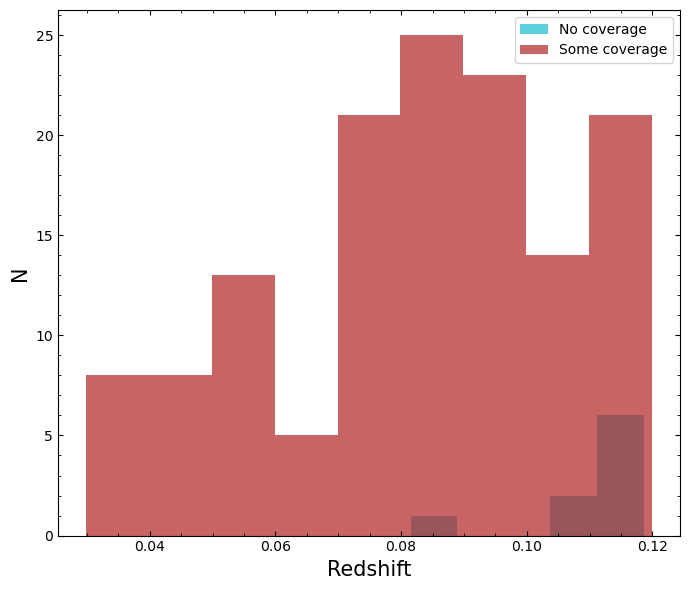

In [17]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(no_cov_samp['redshift'].values, bins='auto', color='tab:cyan', alpha=0.7, label='No coverage')
plt.hist(some_cov_samp['redshift'].values, bins='auto', color='firebrick', alpha=0.7, label='Some coverage')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'Redshift', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

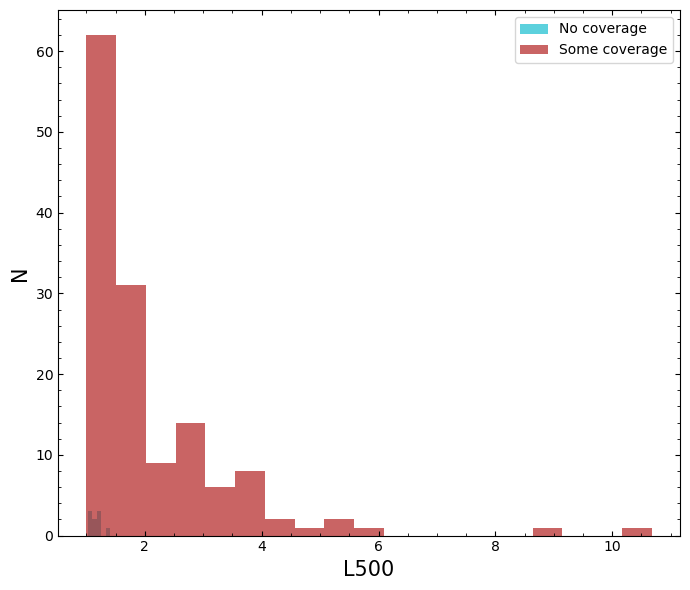

In [18]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(no_cov_samp['L500'].values, bins='auto', color='tab:cyan', alpha=0.7, label='No coverage')
plt.hist(some_cov_samp['L500'].values, bins='auto', color='firebrick', alpha=0.7, label='Some coverage')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'L500', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Incomplete XMM coverage of MCXC $R_{500}$

Those clusters which have some XMM coverage, but a non-unity coverage fraction of $R_{500}$.

In [19]:
samp['xmm_r500_cov_frac'] = r500_xmm_cov_frac
sel_clust = np.where((np.array(r500_xmm_cov_frac) > 0) & (np.array(r500_xmm_cov_frac) < 0.99))
incomp_xmm_r500 = samp.iloc[sel_clust]
incomp_xmm_r500.sort_values('xmm_r500_cov_frac')

ValueError: Length of values (107) does not match length of index (147)

### Clusters with LOFAR coverage

In [ ]:
with fits.open("combined-release-v1.1-LM_opt_mass.fits") as lofaro:
    lof_dat = Table(lofaro[1].data).to_pandas()

In [ ]:
lof_dat.head()

In [ ]:
good_z_lof = lof_dat[~np.isnan(lof_dat['z_best'])]
good_z_lof

In [ ]:
print(list(lof_dat.columns))

In [ ]:
lof_pos = SkyCoord(good_z_lof['RA'].values, good_z_lof['DEC'].values, unit='deg')
lof_pos

In [ ]:
lov_pos = SkyCoord(samp['ra'].values, samp['dec'].values, unit='deg')

match_info = lov_pos.search_around_sky(lof_pos, Quantity(40, 'arcmin'))
match_info

In [ ]:
lov_lof = {}

for ind_ind, lov_ind in enumerate(match_info[1]):
    n = samp.iloc[lov_ind]['LoVoCCS_name']
    if n not in lov_lof:
        lov_lof[n] = []
    
    rel_lof = good_z_lof.iloc[ind_ind]
    lov_lof[n].append(rel_lof)

lov_lof = {n: pd.concat(row_coll, axis=1).T for n, row_coll in lov_lof.items()}